In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

In [ ]:
class AegisCloakingEngine:
    def __init__(self, default_target_path=None):
        """
        Using ResNet50 as a feature extractor.
        - default_target_path: Optional path to a default face to use as the 'mask'.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"--- Aegis Cloaking Engine Initialized on {self.device} ---")

        # Load proxy model (ResNet50)
        resnet = models.resnet50(pretrained=True).to(self.device)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).eval()

        # Image preprocessing for the AI model
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Reverse transform for saving/viewing
        self.denormalize = transforms.Compose([
            transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                 std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.ToPILImage()
        ])
        
        self.default_target_path = default_target_path

    def load_image_as_tensor(self, path):
        """Helper to load image and prepare it for the model."""
        img = Image.open(path).convert('RGB')
        return self.transform(img).unsqueeze(0).to(self.device)

    def generate_cloak(self, input_path, target_path=None, iterations=150, lr=0.01, epsilon=0.03):
        """
        The core Fawkes optimization loop.
        - input_path: Your photo (The one to be protected).
        - target_path: The identity to mimic. If None, uses default_target_path or random push.
        - iterations: Number of optimization steps.
        - lr: Step size for the optimizer.
        - epsilon: Max pixel change (Keep low, e.g., 0.02 - 0.05, for 'invisibility').
        
        Returns: A BGR numpy array (OpenCV format) of the cloaked face.
        """
        # Load Input Image
        input_tensor = self.load_image_as_tensor(input_path)
        input_tensor.requires_grad = True

        # Set Target Identity Handling
        effective_target = target_path if target_path else self.default_target_path
        
        with torch.no_grad():
            if effective_target and os.path.exists(effective_target):
                print(f"Targeting identity from image: {effective_target}")
                target_tensor = self.load_image_as_tensor(effective_target)
                target_features = self.feature_extractor(target_tensor)
            else:
                print("No specific target image found/provided. Using random identity push (High Privacy).")
                target_features = torch.randn(1, 2048, 1, 1).to(self.device)

        # Optimization Loop (Adversarial Attack)
        print(f"Starting Cloaking Process...")
        optimizer = optim.Adam([input_tensor], lr=lr)
        criterion = nn.MSELoss()
        
        for i in range(iterations):
            optimizer.zero_grad()
            current_features = self.feature_extractor(input_tensor)
            
            # Loss: Distance between current features and the target 'identity' features
            loss = criterion(current_features, target_features)
            loss.backward()
            
            with torch.no_grad():
                # Apply sign-based gradient step
                input_tensor -= lr * input_tensor.grad.sign()
                
                # 'Epsilon' constraint: Projects the change back into the allowed 'invisible' range
                delta = torch.clamp(input_tensor - input_tensor.data, -epsilon, epsilon)
                input_tensor.data = input_tensor.data + delta
            
            if i % 30 == 0:
                print(f"Step {i}/{iterations} | Loss: {loss.item():.6f}")

        # Final Image Conversion (Tensor -> PIL -> BGR)
        with torch.no_grad():
            cloaked_img_pil = self.denormalize(input_tensor.squeeze(0).cpu())
            # Convert to BGR for OpenCV compatibility
            cloaked_rgb = np.array(cloaked_img_pil)
            cloaked_bgr = cv2.cvtColor(cloaked_rgb, cv2.COLOR_RGB2BGR)
            return cloaked_bgr

    def save_image(self, image, filename, folder_path="assets/cloakedImage"):
        """Saves the processed image to the specified folder."""
        # Ensure the directory exists
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Created directory: {folder_path}")
        
        full_path = os.path.join(folder_path, filename)
        # image should be BGR numpy array
        success = cv2.imwrite(full_path, image)
        
        if success:
            print(f"Successfully saved image to: {full_path}")
        else:
            print(f"Failed to save image to: {full_path}")
        return full_path

    def show_comparison(self, original_path, cloaked_image):
        """Displays side-by-side comparison in the notebook."""
        orig_bgr = cv2.imread(original_path)
        orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
        clok_rgb = cv2.cvtColor(cloaked_image, cv2.COLOR_BGR2RGB)
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(orig_rgb)
        ax[0].set_title("Original (Human View)")
        ax[0].axis('off')
        
        ax[1].imshow(clok_rgb)
        ax[1].set_title("Cloaked (AI Protected)")
        ax[1].axis('off')
        plt.show()

In [35]:
cloaker = AegisCloakingEngine()

--- Aegis Cloaking Engine Initialized on cpu ---


c:\Users\rishi\Desktop\Workspace\PROJECTS\Aegis\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rishi\Desktop\Workspace\PROJECTS\Aegis\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
input_img = "assets/samples/face1.jpg"
# reduce epsilon for removing graininess
# increase iterartion for more invisibility
cloaked_face = cloaker.generate_cloak(input_img, target_path="", iterations=500, lr=0.001,epsilon=0.02)


No specific target image found/provided. Using random identity push (High Privacy).
Starting Cloaking Process...
Step 0/500 | Loss: 1.111267
Step 30/500 | Loss: 0.929612
Step 60/500 | Loss: 0.908256
Step 90/500 | Loss: 0.897640
Step 120/500 | Loss: 0.890280
Step 150/500 | Loss: 0.884786
Step 180/500 | Loss: 0.880334
Step 210/500 | Loss: 0.877231
Step 240/500 | Loss: 0.874069
Step 270/500 | Loss: 0.871560
Step 300/500 | Loss: 0.869500
Step 330/500 | Loss: 0.867789
Step 360/500 | Loss: 0.865932
Step 390/500 | Loss: 0.864269
Step 420/500 | Loss: 0.862836
Step 450/500 | Loss: 0.861741
Step 480/500 | Loss: 0.860484


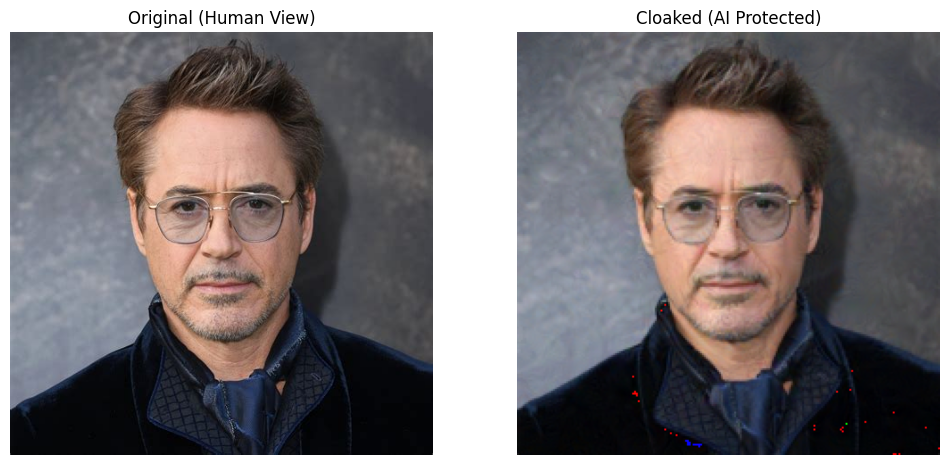

In [37]:
cloaker.show_comparison(input_img, cloaked_face)


In [32]:
cloaker.save_image(cloaked_face, f"cloakedImg{int(1e7*(time.time()-int(time.time())))}.png")

Successfully saved image to: assets/cloakedImage\cloakedImg6928334.png


'assets/cloakedImage\\cloakedImg6928334.png'

## Batch Processing

In [6]:
import glob

def process_folder(input_folder, target_path=None, output_folder="assets/cloakedImage"):
        """
        Scans a folder for images and cloaks every one of them.
        """
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp']
        image_files = []
        for ext in extensions:
            image_files.extend(glob.glob(os.path.join(input_folder, ext)))
        
        if not image_files:
            print(f"No images found in {input_folder}")
            return

        print(f"Found {len(image_files)} images. Starting batch cloaking...")
        
        for img_path in image_files:
            filename = os.path.basename(img_path)
            print(f"Processing: {filename}...")
            
            try:
                cloaked_img = cloaker.generate_cloak(img_path, target_path=target_path)
                cloaker.save_image(cloaked_img, f"cloaked_{filename}", output_folder)
            except Exception as e:
                print(f"Skipping {filename} due to error: {e}")


In [7]:
process_folder(input_folder='assets/tomCruise',target_path="assets/samples/face1.jpg")

Found 6 images. Starting batch cloaking...
Processing: 001_08212dcd.jpg...
Targeting identity from image: assets/samples/face1.jpg
Starting Cloaking Process...
Step 0/150 | Loss: 0.079723
Step 30/150 | Loss: 0.011917
Step 60/150 | Loss: 0.007545
Step 90/150 | Loss: 0.006264
Step 120/150 | Loss: 0.004554
Successfully saved image to: assets/cloakedImage\cloaked_001_08212dcd.jpg
Processing: 002_6749a2c4.jpg...
Targeting identity from image: assets/samples/face1.jpg
Starting Cloaking Process...
Step 0/150 | Loss: 0.077500
Step 30/150 | Loss: 0.012790
Step 60/150 | Loss: 0.006454
Step 90/150 | Loss: 0.006004
Step 120/150 | Loss: 0.004437
Successfully saved image to: assets/cloakedImage\cloaked_002_6749a2c4.jpg
Processing: 003_ed3fb7b1.jpg...
Targeting identity from image: assets/samples/face1.jpg
Starting Cloaking Process...
Step 0/150 | Loss: 0.096747
Step 30/150 | Loss: 0.013196
Step 60/150 | Loss: 0.007674
Step 90/150 | Loss: 0.005997
Step 120/150 | Loss: 0.004707
Successfully saved imag

In [ ]:
# https://teachablemachine.withgoogle.com/models/OQSxfAz9x/